#  TitanicQASystem

- Author: [Taylor(Jihyun Kim)](https://github.com/Taylor0819)
- Design: 
- Peer Review: [Jongcheol Kim](https://github.com/greencode-99), [Heesun Moon](https://github.com/MoonHeesun)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/03-GraphDB/05-TitanicQASystem.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/03-GraphDB/05-TitanicQASystem.ipynb)



## Overview
In this tutorial, we walk through building a Q&A system with the Titanic dataset stored in a `Neo4j` graph. 

Starting with a csv file, we preprocess passenger data and model both nodes (Passenger) and relationships (`MARRIED_TO` , `SIBLING_OF` , `PARENT_OF` ) in `Neo4j` . 

LangChain then transforms user questions into Cypher queries that retrieve key insights, while langgraph handles invalid queries by allowing an LLM to revise them based on Neo4j feedback. 

Ultimately, you gain a robust pipeline to analyze relationships, compute statistics, and explore passenger connections in the Titanic dataset.

1. Setup & Data Preparation  
   - Acquire and clean the Titanic csv file.  
   - Preprocess passenger data by handling missing values and extracting relevant fields.

2. Graph Modeling in Neo4j
   - Create `Passenger` nodes with core properties (e.g., `age`, `ticket`, `survived`).  
   - Establish relationships such as:
     - `MARRIED_TO`  
     - `SIBLING_OF` 
     - `PARENT_OF` 

3. Querying with LangChain
   - Convert natural-language questions into Cypher queries.  
   - Retrieve insights like family ties, survival rates, and ticket usage.

4. Error Handling with langgraph 
   - Catch and correct invalid queries.  
   - Provide Neo4j feedback to an LLM, automatically revising problematic Cypher statements.

5. Outcome  
   - By the end, you'll have a **robust Q&A system** for exploring passenger connections, computing statistics, and discovering meaningful patterns in the Titanic dataset stored in Neo4j.

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Load Titanic data](#load-titanic-data)
- [Neo4j Database Connection](#neo4j-database-connection)
- [Consider the Data with Arrows.app](#consider-the-data-with-arrows.app)
- [Data Restructure](#data-restructure)
- [Usage Example](#usage-example)


### References
- [Neo4j Arrows](https://neo4j.com/labs/arrows)
- [LangChain Neo4j](https://python.langchain.com/docs/integrations/graphs/neo4j_cypher)
- [Langchain Neo4j Advanced Implementation with langgraph](https://python.langchain.com/docs/tutorials/graph/#query-validation)
----

## Environment Setup
Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]** 

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["langsmith", "langchain_neo4j", "langchain_openai", "langgraph"],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "05-FAQRAGSystem",
        "NEO4J_URI": "",
        "NEO4J_USERNAME": "",
        "NEO4J_PASSWORD": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
import os
import nest_asyncio

# Allow async
nest_asyncio.apply()

## Load Titanic Data

### Data Preparation

In this tutorial, we will use the following csv file:

- Download Link: [Kaggle Titanic Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset)
- Author : M Yasser H (kaggle ID)
- File name: Titanic-Dataset.csv"
- File path: "./data/Titanic-Dataset.csv"

There are two ways to obtain the dataset:

1. Download directly from the Kaggle link above
2. Use the Python code below to automatically download via Kaggle API

In [6]:
# Download and save sample csv file to ./data directory
import requests
import zipfile

def download_csv(url, zip_path, extract_dir):
    """
    Downloads a csv file from the given URL and saves it to the specified path.

        Args:
        url (str): The URL of the csv file to download
        zip_path (str): The full path (including file name) where the zip file will be temporarily saved
        extract_dir (str): The directory path where the contents will be extracted
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(zip_path), exist_ok=True)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the file to the specified path
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        # Extract the zip file
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_dir)

        print(f"File downloaded and extracted to {extract_dir}")

        # Delete the temporary zip file (optional)
        os.remove(zip_path)
        print(f"Temporary zip file deleted: {zip_path}")

    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"csv downloaded and saved to: {zip_path}")


# Configuration for the PDF file
url = "https://www.kaggle.com/api/v1/datasets/download/yasserh/titanic-dataset"
zip_path = "./data/data.zip"
extract_dir = "./data"

# Download the PDF
download_csv(url, zip_path, extract_dir)

File downloaded and extracted to ./data
Temporary zip file deleted: ./data/data.zip


In [7]:
import pandas as pd

file_path = "./data/Titanic-Dataset.csv"

# Read csv file
df = pd.read_csv(file_path)

# check data structure, sample data
print("=== DataFrame Info ===")
df.info()

print("=== Sample data ===")
df.head()

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
=== Sample data ===


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Column Descriptions
Key column descriptions:
- `PassengerId` : Unique identifier for each passenger
- `Survived` : Survival status (0 = No, 1 = Yes)
- `Pclass` : Ticket class (1, 2, 3)
- `Name` : Passenger name
- `Sex` : Gender
- `Age` : Age in years
- `SibSp` : Number of siblings/spouses aboard
- `Parch` : Number of parents/children aboard
- `Ticket` : Ticket number
- `Fare` : Passenger fare
- `Cabin` : Cabin number
- `Embarked` : Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Simple Data Preprocessing
- Creating `LastName` Column: Extracts the last name from the Name column and stores it in a new column LastName. The extraction is done by splitting the string at the comma and using the first element.
- Removing Missing Values: Drops rows where the `Age` column has null values to ensure data completeness.
- Data Type Conversion: Converts the `Ticket` column to string format to maintain consistency in data types.

In [8]:
# Optional: parse last names from "Name" if helpful
df["LastName"] = df["Name"].apply(lambda x: x.split(",")[0].strip())

# Drop rows where Age is null
df.dropna(subset=["Age"], inplace=True)

# Convert "Ticket" to a string type to maintain consistency
df["Ticket"] = df["Ticket"].astype(str)

In [9]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


# Neo4j Database Connection
This tutorial is based on Neo4j Desktop. First, install the Neo4j graph database from [Neo4j Desktop Installation link](https://neo4j.com/docs/operations-manual/current/installation/)

[Note] 
You can set up Neo4j in several ways 

1. [`Neo4j Desktop`](https://neo4j.com/docs/operations-manual/current/installation/) :  A desktop application for local development

2. [`Neo4j Sandbox` ](https://neo4j.com/sandbox/) : A free, cloud-based platform for working with graph databases

3. [`Docker` ](https://neo4j.com/docs/operations-manual/current/docker/) : Run Neo4j in a container using the official Neo4j Docker image

**[Important]** Before importing the csv file, Please follow the setup instructions in the link: 

[03-GraphDB/04-MovieQASystem](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/03-GraphDB/04-MovieQASystem.ipynb)

1. Setup APOC Plugin
2. Update the neo4j.conf file.



### Define Neo4j Credentials

Next, you need to define your `Neo4j` credentials. If you haven't done this in the previous steps, you can define them using the os package.

[Note] This is not necessary if you've already set the required `Neo4j` credentials in previous steps.

>The default user account information:
>
>- Default username: `neo4j`
>
>- Default password: `neo4j`
>
>You are required to change the password upon your first login.



In [10]:
import os

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "taylor"
os.environ["NEO4J_PASSWORD"] = "titanic12"

### Import Titanic data
[How to Import csv File into Neo4j](https://neo4j.com/docs/getting-started/appendix/tutorials/guide-import-desktop-csv/#csv-location)

We will import a csv file into the Neo4j Desktop by adding it to the `import` folder.

To open a finder window, hover over the three dots on the right side of the started DBMS, select `Open folder` , and then click `Import` 
![explanation-02](./assets/05-titanicqasystem-flow-explanation-02.png)

You can directly drag & drop files into this folder to add them.
![explanation-03](./assets/05-titanicqasystem-flow-explanation-03.png)


Let's verify the data import using Neo4j Browser.
![explanation-04](./assets/05-titanicqasystem-flow-explanation-04.png)

We will use a simple Cypher query to verify that the data has been successfully added:

This query will count the number of rows in the Titanic-Dataset.csv file and return the total count. If the data is accessible and correctly loaded, you will see the total row count in the result.

>CYPER : LOAD CSV FROM 'file:///Titanic-Dataset.csv' AS row
RETURN count(row);

![explanation-05](./assets/05-titanicqasystem-flow-explanation-05.png)
![explanation-06](./assets/05-titanicqasystem-flow-explanation-06.png)

It has been successfully loaded!


In [11]:
from langchain_neo4j import Neo4jGraph

uri = os.environ["NEO4J_URI"]
username = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]

try:
    graph = Neo4jGraph(
        url=uri, username=username, password=password, enhanced_schema=True
    )
    print("Successfully connected to Neo4j")
except Exception as e:
    print(f"Connection error: {str(e)}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Successfully connected to Neo4j


# Consider the data with Arrows.app
When converting a complete tabular dataset like a passenger manifest into a graph, it may seem simple to create nodes for each `Person`, `tickets`, and `Embarked points` while turning the remaining columns into properties. 

However, the flexibility of the graph structure requires careful consideration of how to categorize data into nodes, relationships, or properties. The way the data is structured may vary depending on the types of queries you plan to run on the graph.

To assist with this, Neo4j provides `Arrows.app`, a tool that allows you to visualize relationships across the graph before uploading any specific data. With [arrows.app](https://arrows.app), you can explore and experiment with different ways to model the data. To demonstrate this, I will present an example graph that represents a complex data structure.

### Defining the Relationship Categories
The first step was to define the categories of relationships we were interested in.
Here are the three relationships I had to define: `MARRIED_TO` , `SIBLING_TO` , `PARENT_OF`.

![explanation-01](./assets/05-titanicqasystem-flow-explanation-01.png)

Both `MARRIED_TO` and `SIBLING_TO` would imply the same relationship in the other direction between the same nodes. 

`PARENT_OF` would imply a reverse relationship of `CHILD_OF` .


## Data Restructure
### Why We Create Passenger Nodes

We create `Passenger` nodes to represent each Titanic passenger in the graph database. 

This enables us to:
- Assign properties (e.g., `age` , `ticket` , `survived` ) directly to a node.
- Connect these person with relationships to other entities (e.g., `SIBLING_OF` , `MARRIED_TO` , `PARENT_OF` ) once we identify family links or other relevant data points.
- Query the graph to analyze connections, run aggregations on survivor counts, family group structures, or other correlations inherent in the Titanic dataset.

By modeling person as nodes, `Neo4j` can leverage its graph capabilities (like path finding, pattern matching, or graph algorithms) to deliver deeper insights than a traditional relational or tabular approach might.

In [12]:
cypher = """
UNWIND $person AS row
MERGE (p:Passenger { passengerId: toInteger(row.PassengerId) })
ON CREATE SET
    p.name      = row.Name,
    p.lastName  = row.LastName,
    p.age       = CASE WHEN row.Age <> '' THEN toFloat(row.Age) ELSE null END,
    p.sex       = row.Sex,
    p.survived  = row.Survived,
    p.sibsp     = CASE WHEN row.SibSp <> '' THEN toInteger(row.SibSp) ELSE 0 END,
    p.parch     = CASE WHEN row.Parch <> '' THEN toInteger(row.Parch) ELSE 0 END,
    p.family    = CASE
                     WHEN row.SibSp <> '' AND row.Parch <> ''
                     THEN toInteger(row.SibSp) + toInteger(row.Parch)
                     ELSE 0
                  END,
    p.ticket    = row.Ticket,
    p.pclass    = CASE WHEN row.Pclass <> '' THEN toInteger(row.Pclass) ELSE null END,
    p.fare      = CASE WHEN row.Fare <> '' THEN toFloat(row.Fare) ELSE null END,
    p.embarked  = row.Embarked
RETURN count(*) AS total
"""

params = {"person": df.to_dict("records")}

graph.query(cypher, params)

# 확인 쿼리 (Python에서)
result = graph.query("MATCH (t:Ticket) RETURN count(t) AS ticketCount")
print("Ticket node count:", result)

graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Ticket node count: [{'ticketCount': 0}]
Node properties:
- **Passenger**
  - `name`: STRING Example: "Braund, Mr. Owen Harris"
  - `lastName`: STRING Example: "Braund"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "A/5 21171"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['S', 'C', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
Relationship properties:

The relationships:



Verifying Nodes in Neo4j Browser

Cypher query:
>MATCH (n:Passenger) RETURN n LIMIT 10

![explanation-07](./assets/05-titanicqasystem-flow-explanation-07.png)
The nodes have been successfully created!

In [13]:
ticket_node_query = """
UNWIND $person AS row
MERGE (t:Ticket {ticketNo: row.Ticket})
"""
params = {"person": df.to_dict("records")}

# Execute Query
graph.query(ticket_node_query, params)

result = graph.query("MATCH (t:Ticket) RETURN count(t) AS ticketCount")
print("Ticket node count:", result)

Ticket node count: [{'ticketCount': 542}]


In [14]:
travel_on_query = """
UNWIND $person AS row
MATCH (p:Passenger { passengerId: toInteger(row.PassengerId) })
MATCH (t:Ticket { ticketNo: row.Ticket })
MERGE (p)-[:TRAVELED_ON]->(t)
RETURN count(*) AS totalEdges
"""
# Execute Query
rel_result = graph.query(travel_on_query, params)
print("TRAVELED_ON relationships created:", rel_result)

TRAVELED_ON relationships created: [{'totalEdges': 714}]


In [15]:
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Passenger**
  - `name`: STRING Example: "Braund, Mr. Owen Harris"
  - `lastName`: STRING Example: "Braund"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "A/5 21171"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['S', 'C', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
- **Ticket**
  - `ticketNo`: STRING Example: "349241"
Relationship properties:

The relationships:
(:Passenger)-[:TRAVELED_ON]->(:Ticket)


### Why Create These Relationships?

1.	`MARRIED_TO` 
Infers a couple is married if they share the same Ticket, have the same LastName, have sibsp = 1 (i.e., exactly one sibling/spouse count in the data), differ in sex, and a few additional age-based checks.

2.	`SIBLING_OF` 
Among those not married, uses SibSp, LastName, Ticket, and other constraints (e.g., (p2).parch = 1 or 2) to guess they’re siblings if they appear to have the same “family” context but are not recognized as spouses.

3. `PARENT_OF` (and/or `CHILD_OF` )
If the passenger has parch >= 1 (parents/children on board), is older than some threshold, or specifically older than the potential child, create PARENT_OF edges.

These queries are heuristics to reconstruct plausible family connections from partial data. They rely on simplified assumptions—such as “If two people share a ticket, they might be family,” “If a passenger’s sibsp=1, that single sibling/spouse is probably a spouse rather than a child,” etc. You can refine or alter the logic to fit your own inference approach.

### Key Idea
< `MARRIED_TO` >
1. Find passengers (person, other) who share the same ticket using the `TRAVELED_ON` relationship.

2. Create a **family members list** by collecting others (collect(other)) after `ORDER BY other.age DESC` .

3. Consider familyMembers[0] (the oldest person) as the "spouse candidate" or "family representative".

4. Use `FOREACH`(... `CREATE` ...) statement to create relationships only for passengers meeting specific conditions.

5. p2 = familyMembers[0] → "Only consider the oldest (or first) person as a spouse candidate"

6. (`size(familyMembers) = 1` OR `p1.age > familyMembers[1].age` ) → Complex conditions like "If there's only one family member, or if p1 is older than the second oldest person..."

If passengers share the same ticket + same family + sibsp=1 , they are considered spouses, processing only the first person by family age order as a spouse.


In [16]:
# MARRIED_TO
married_query = """
MATCH (person:Passenger)
WHERE person.age IS NOT NULL
MATCH (person)-[:TRAVELED_ON]->(ticket:Ticket)<-[:TRAVELED_ON]-(other:Passenger)
WHERE other.age IS NOT NULL
  AND person.family = other.family
WITH person, other
ORDER BY other.age DESC
WITH person AS p1, collect(other) AS familyMembers
WITH p1, familyMembers,
     [p2 IN familyMembers
        WHERE p1.sibsp = 1
          AND p2.sibsp = 1
          AND p2.family >= 1
          AND p2.sex <> p1.sex
          AND p2 = familyMembers[0]
          AND (size(familyMembers) = 1 OR p1.age > familyMembers[1].age)
     ] AS spouses
FOREACH (p IN spouses | CREATE (p1)-[:MARRIED_TO]->(p))
"""

graph.query(married_query)
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Passenger**
  - `name`: STRING Example: "Braund, Mr. Owen Harris"
  - `lastName`: STRING Example: "Braund"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "A/5 21171"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['S', 'C', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
- **Ticket**
  - `ticketNo`: STRING Example: "349241"
Relationship properties:

The relationships:
(:Passenger)-[:TRAVELED_ON]->(:Ticket)
(:Passenger)-[:MARRIED_TO]->(:Passenger)


< `SIBLING_OF` & `PARENT_OF` >

1. Find passengers sharing the same ticket and family name using `TRAVELED_ON` relationship.

2. Create a **family members list** ordered by age (`ORDER BY other.age DESC`).

3. Identify siblings based on conditions:
- Not married (no `MARRIED_TO` relationship)
- Has siblings (`sibsp >= 1`)
- Same sibsp value between passengers
- `Family value >= 1`
- Parent/child count (parch) is 1 or 2
- Not the oldest family member

4. Identify children based on conditions:
- Not married
- Not in siblings list
- `Family value >= 1`
- Parent/child count is 1 or 2
- Age comparison (`p1 older than p2`)


In [17]:
# SIBLING_OF & PARENT_OF

sibling_parent_query = """
    MATCH (person:Passenger)
    WHERE person.age IS NOT NULL
    MATCH (person:Passenger)-[:TRAVELED_ON]->(ticket:Ticket)<-[:TRAVELED_ON]-(other:Passenger)
    WHERE other.age IS NOT NULL AND person.family = other.family
    WITH person, other
    ORDER BY other.age DESC
    WITH person as p1, collect(other) as familyMembers
    WITH p1, familyMembers, [p2 in familyMembers WHERE
    NOT (p2)-[:MARRIED_TO]->() AND
    NOT (p1)-[:MARRIED_TO]->() AND
    p2.sibsp >= 1 AND
    p2.sibsp = p1.sibsp AND
    p2.family >= 1 AND
    (p2.parch = 1 OR p2.parch = 2) AND
    NOT p2 = familyMembers [0] AND
    NOT p1 = familyMembers [0] 
    ] as siblings
    WITH p1, familyMembers, siblings, [p2 in familyMembers WHERE
    NOT (p2)-[:MARRIED_TO]->() AND
    NOT p2 IN siblings AND
    NOT p1 IN siblings AND 
    p2.family >= 1 AND
    (p2.parch = 1 OR p2.parch = 2) AND
    p1.parch >= 1 AND
    p1.age > p2.age
    ] as children
FOREACH (p in siblings | CREATE (p1)-[:SIBLING_OF]->(p))
FOREACH (p in children | CREATE (p1)-[:PARENT_OF]->(p))
"""

graph.query(sibling_parent_query)
graph.refresh_schema()
print(graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Passenger**
  - `name`: STRING Example: "Braund, Mr. Owen Harris"
  - `lastName`: STRING Example: "Braund"
  - `age`: FLOAT Min: 0.42, Max: 80.0
  - `sex`: STRING Available options: ['male', 'female']
  - `survived`: INTEGER Min: 0, Max: 1
  - `sibsp`: INTEGER Min: 0, Max: 5
  - `parch`: INTEGER Min: 0, Max: 6
  - `ticket`: STRING Example: "A/5 21171"
  - `pclass`: INTEGER Min: 1, Max: 3
  - `fare`: FLOAT Min: 0.0, Max: 512.3292
  - `embarked`: STRING Available options: ['S', 'C', 'Q', 'NaN']
  - `family`: INTEGER Min: 0, Max: 7
  - `passengerId`: INTEGER Min: 1, Max: 891
- **Ticket**
  - `ticketNo`: STRING Example: "349241"
Relationship properties:

The relationships:
(:Passenger)-[:TRAVELED_ON]->(:Ticket)
(:Passenger)-[:MARRIED_TO]->(:Passenger)
(:Passenger)-[:SIBLING_OF]->(:Passenger)
(:Passenger)-[:PARENT_OF]->(:Passenger)


### Consider the Data with Neo4j Desktop Visualization

While we often handle and analyze large datasets using machine learning and deep learning techniques, visualizing data relationships through graph databases like Neo4j offers unique insights. The attached node visualization from `Neo4j Desktop` demonstrates the intricate connections within our Titanic dataset.

This graph-based approach allows us to:
1. Discover hidden patterns in passenger relationships
2. Analyze survival rates based on social connections
3. Identify clusters of passengers with similar characteristics
4. Explore complex relationships that might be missed in traditional tabular analysis

By combining these visual insights with ML/DL approaches, we can develop a more comprehensive understanding of the data and potentially uncover novel patterns that might be overlooked using traditional analysis methods alone.

**[Attached: Neo4j Desktop visualization of Titanic dataset relationships]**

![explanation-08](./assets/05-titanicqasystem-flow-explanation-08.png)

# Usage Example
Exploring Titanic Dataset with `Neo4j` and `LangGraph`

When converting natural language into Cypher queries, the process doesn’t always succeed on the first try. Queries can fail for various reasons:
1. Nonexistent columns or properties
2. Typos in relationship or node labels
3. Logical mistakes leading to syntax errors

To handle these challenges, this tutorial demonstrates:
- Robust error handling for query validation
- Property existence checking before query execution
- Automated syntax verification using `EXPLAIN`
- Smart query reformulation using LLMs
- Step-by-step debugging techniques for complex queries

In [18]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))

In [19]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain_neo4j import GraphCypherQAChain

schema = graph.schema

# PROMPT SETUP
# Our schema + usage instructions referencing the Titanic relationships

TITANIC_SCHEMA_PROMPT = """
You have a Neo4j database with a 'Passenger' node label, which includes properties:
- Passenger [ id, name, age, sex, survived, sibsp, parch, ticket, pclass, fare, embarked ]

Schema: 
{schema}

Relationships (inferred from the Titanic blog):
- :SIBLING_OF
- :MARRIED_TO
- :PARENT_OF

Rules:
- If the user mentions siblings, brother, or sister, use :SIBLING_OF.
- If the user mentions spouse, married, husband, or wife, use :MARRIED_TO.
- If the user mentions parent, child, mother, or father, use :PARENT_OF
- Do not invent new relationship names. Only use the 4 types above if relevant.
- The node label is only 'Passenger'. Do not invent new labels.
- Use MATCH (p:Passenger) to reference person. 
- Return your Cypher query in a single code block.

Examples : 

**Example 1**  
**Natural language**: "Find me all the spouses of Mr. John Smith."  
**Cypher**: "MATCH (p:Passenger {{name: "John Smith"}})-[:MARRIED_TO]->(spouse:Passenger)
RETURN spouse.name AS spouseName"

The question is:
{question}

"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=TITANIC_SCHEMA_PROMPT
)
print(CYPHER_GENERATION_PROMPT)

# Initialize the QA chain with GPT-4o and Neo4j graph
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(model="gpt-4o", temperature=0, api_key=os.getenv("OPENAI_API_KEY")),
    graph=graph,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,
)

# Example query 1 to find the passenger with the most siblings
chain.invoke({"query": "Which passenger has the most siblings?"})

input_variables=['question', 'schema'] input_types={} partial_variables={} template='\nYou have a Neo4j database with a \'Passenger\' node label, which includes properties:\n- Passenger [ id, name, age, sex, survived, sibsp, parch, ticket, pclass, fare, embarked ]\n\nSchema: \n{schema}\n\nRelationships (inferred from the Titanic blog):\n- :SIBLING_OF\n- :MARRIED_TO\n- :PARENT_OF\n\nRules:\n- If the user mentions siblings, brother, or sister, use :SIBLING_OF.\n- If the user mentions spouse, married, husband, or wife, use :MARRIED_TO.\n- If the user mentions parent, child, mother, or father, use :PARENT_OF\n- Do not invent new relationship names. Only use the 4 types above if relevant.\n- The node label is only \'Passenger\'. Do not invent new labels.\n- Use MATCH (p:Passenger) to reference person. \n- Return your Cypher query in a single code block.\n\nExamples : \n\n**Example 1**  \n**Natural language**: "Find me all the spouses of Mr. John Smith."  \n**Cypher**: "MATCH (p:Passenger {{

{'query': 'Which passenger has the most siblings?',
 'result': 'Panula, Master. Juha Niilo has the most siblings, with a sibling count of 4.'}

In [20]:
# Example query 2
chain.invoke(
    {
        "query": "Tell me about the conditions that will give me the highest chance of survival."
    }
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Passenger)
WITH 
  p.pclass AS class, 
  p.sex AS sex, 
  CASE 
    WHEN p.age < 18 THEN 'child' 
    ELSE 'adult' 
  END AS ageGroup, 
  AVG(p.survived) AS survivalRate
RETURN 
  class, 
  sex, 
  ageGroup, 
  survivalRate
ORDER BY 
  survivalRate DESC

Full Context:
[{'class': 2, 'sex': 'female', 'ageGroup': 'child', 'survivalRate': 1.0}, {'class': 1, 'sex': 'male', 'ageGroup': 'child', 'survivalRate': 1.0}, {'class': 1, 'sex': 'female', 'ageGroup': 'adult', 'survivalRate': 0.9740259740259738}, {'class': 2, 'sex': 'female', 'ageGroup': 'adult', 'survivalRate': 0.9032258064516127}, {'class': 1, 'sex': 'female', 'ageGroup': 'child', 'survivalRate': 0.875}, {'class': 2, 'sex': 'male', 'ageGroup': 'child', 'survivalRate': 0.8181818181818181}, {'class': 3, 'sex': 'female', 'ageGroup': 'child', 'survivalRate': 0.5428571428571428}, {'class': 3, 'sex': 'female', 'ageGroup': 'adult', 'survivalRate': 0.4179104477611

{'query': 'Tell me about the conditions that will give me the highest chance of survival.',
 'result': 'The highest chance of survival is for children, regardless of sex, in class 1 or class 2, with a survival rate of 1.0.'}

In [21]:
# Example query 3
chain.invoke(
    {
        "query": "What is the survival rate comparison between passengers with children and those without children?"
    }
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
// Calculate survival rate for passengers with children
MATCH (p:Passenger)-[:PARENT_OF]->(:Passenger)
WITH COUNT(p) AS totalWithChildren, SUM(p.survived) AS survivedWithChildren

// Calculate survival rate for passengers without children
MATCH (p:Passenger)
WHERE NOT (p)-[:PARENT_OF]->(:Passenger)
WITH totalWithChildren, survivedWithChildren, COUNT(p) AS totalWithoutChildren, SUM(p.survived) AS survivedWithoutChildren

// Calculate survival rates
RETURN 
  (survivedWithChildren * 1.0 / totalWithChildren) AS survivalRateWithChildren,
  (survivedWithoutChildren * 1.0 / totalWithoutChildren) AS survivalRateWithoutChildren

Full Context:
[{'survivalRateWithChildren': 0.3838383838383838, 'survivalRateWithoutChildren': 0.39663093415007655}]

> Finished chain.


{'query': 'What is the survival rate comparison between passengers with children and those without children?',
 'result': 'The survival rate for passengers with children is 38.38%, while for those without children, it is 39.66%.'}

### Usage Example using Langgraph
**Why Use langgraph?** 

Sometimes, natural language can’t be directly or accurately converted to a valid Cypher query on the first try. The query might fail for various reasons:
1.	Nonexistent Columns or Properties
2.	Typos in relationship labels or node labels
3.	Logical Mistakes leading to syntax errors

Instead of manually fixing the query, we can automate the process:
1.	Ask an LLM to generate a query from a user’s question.
2.	Try running the query against `Neo4j` .
3.	If it fails, capture the error message and feed it back to the LLM so it can revise the query.
4.	Retry until a valid query is produced or we exceed the maximum number of attempts.

This iterative approach significantly improves robustness when handling open-ended user questions.


In [22]:
from typing_extensions import TypedDict
from operator import add
from typing import Annotated, List
from langchain_core.prompts import ChatPromptTemplate

class InputState(TypedDict):
    question: str

class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]

class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
                Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
                Here is the schema information  
                {schema}

                Relationships (inferred from the Titanic blog):
                - :SIBLING_OF
                - :MARRIED_TO
                - :PARENT_OF

                Below are a number of examples of questions and their corresponding Cypher queries.

                **User input**: "Find me all the spouses of Mr. John Smith."  
                **Cypher query**: "MATCH (p:Passenger {{name: "John Smith"}})-[:MARRIED_TO]->(spouse:Passenger)
                RETURN spouse.name AS spouseName"

                User input: {question}
                Cypher query:"""
            ),
        ),
    ]
)


In [23]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))

def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """

    try:
       
        # Create the text2cypher chain
        text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()

        generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": graph.schema
        })

        return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

    except Exception as e:
        return {"error_message": str(e), "steps": ["cypher_rewriter_node"]}

First, we will create a chain that detects any errors in the Cypher statement and extracts the property values it references.

In [24]:
from typing import Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

# Create the validate_cypher_prompt
validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


In [25]:
from pydantic import BaseModel, Field

class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: Optional[str] = Field(
        default=None,
        description="The value that the property is being matched against."
    )

class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

LLMs often struggle with correctly determining relationship directions in generated Cypher statements. Since we have access to the schema, we can deterministically correct these directions using the CypherQueryCorrector.

Note: The [CypherQueryCorrector](https://python.langchain.com/api_reference/neo4j/chains/langchain_neo4j.chains.graph_qa.cypher_utils.CypherQueryCorrector.html) is an experimental feature and doesn't support all the newest Cypher syntax. 

In [26]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

Now we can implement the Cypher validation step. First, we use the `EXPLAIN` method to detect any syntax errors. Next, we leverage the LLM to identify potential issues and extract the properties used for filtering. For string properties, we validate them against the database using a simple `CONTAINS` clause.

Based on the validation results, the process can take the following paths:

- If value mapping fails, we end the conversation and inform the user that we couldn't identify a specific property value (e.g., a passenger name or ticket number).
- If errors are found, we route the query for correction.
- If no issues are detected, we proceed to the Cypher execution step.

In [27]:
from neo4j.exceptions import CypherSyntaxError

def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Experimental feature for correcting relationship directions
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

The Cypher correction step takes the existing Cypher statement, any identified errors, and the original question to generate a corrected version of the query.

In [28]:
# Create the correct_cypher_prompt
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)


In [29]:
# Create the correct_cypher_chain
correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()

def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

We need to add a step that executes the given Cypher statement. If no results are returned, we should explicitly handle this scenario, as leaving the context empty can sometimes lead to LLM hallucinations.

In [30]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

The final step is to generate the answer. This involves combining the initial question with the database output to produce a relevant response.

In [31]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()

def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to the database.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

Next, we will implement the LangGraph workflow, starting with defining the conditional edge functions.

In [32]:
from typing import Optional, Literal

def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

Let's put it all together now.

In [33]:
# Build the Workflow
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition

app = StateGraph(OverallState, input=InputState, output=OutputState)

app.add_node(generate_cypher)
app.add_node(validate_cypher)
app.add_node(correct_cypher)
app.add_node(execute_cypher)
app.add_node(generate_final_answer)

app.add_edge(START, "generate_cypher")

app.add_edge("generate_cypher", "validate_cypher")
app.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
app.add_edge("execute_cypher", "generate_final_answer")
app.add_edge("correct_cypher", "validate_cypher")
app.add_edge("generate_final_answer", END)

workflow = app.compile()


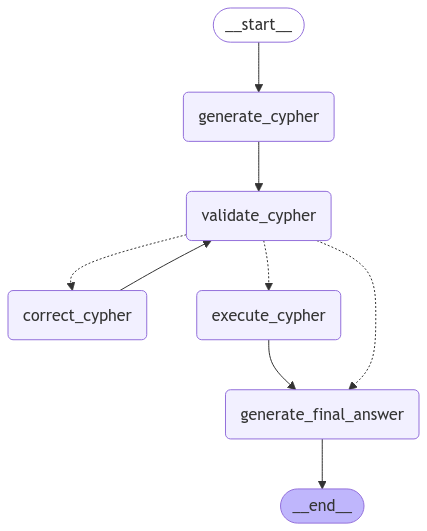

In [34]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the compiled StateGraph as a Mermaid diagram
display(Image(workflow.get_graph().draw_mermaid_png()))

In [35]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage

# Config settings with checkpoint configuration
config = RunnableConfig(
    recursion_limit=10,
    configurable={
        "thread_id": "test_123",
    },
)

for chunk in workflow.stream({"question": "Which ticket was used by the largest family to travel?"}, config):
    print(chunk)
    print("----")


{'generate_cypher': {'cypher_statement': 'MATCH (p:Passenger)-[:TRAVELED_ON]->(t:Ticket)\nRETURN t.ticketNo AS ticketNumber, SUM(p.family) AS familySize\nORDER BY familySize DESC\nLIMIT 1', 'steps': ['generate_cypher']}}
----
{'validate_cypher': {'next_action': 'execute_cypher', 'cypher_statement': 'MATCH (p:Passenger)-[:TRAVELED_ON]->(t:Ticket)\nRETURN t.ticketNo AS ticketNumber, SUM(p.family) AS familySize\nORDER BY familySize DESC\nLIMIT 1', 'cypher_errors': [], 'steps': ['validate_cypher']}}
----
{'execute_cypher': {'database_records': [{'ticketNumber': '347082', 'familySize': 42}], 'next_action': 'end', 'steps': ['execute_cypher']}}
----
{'generate_final_answer': {'answer': 'The ticket used by the largest family to travel was ticket number 347082.', 'steps': ['generate_final_answer']}}
----
